In [21]:
import pandas
import numpy
from scipy.stats import binom
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

url = ('https://github.com/dhesse/IN-STK5000-Autumn21'
       '/raw/main/compas-scores-two-years.csv.gz')
data = pandas.read_csv(url)

In [2]:
data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


## Point Estimate

In [3]:
data.groupby('age_cat')['two_year_recid'].mean()

age_cat
25 - 45            0.459723
Greater than 45    0.315990
Less than 25       0.565075
Name: two_year_recid, dtype: float64

## Bootstrap

In [6]:
bss = pandas.DataFrame([data.sample(data.shape[0], replace=True)\
 .groupby('age_cat')['two_year_recid'].mean()
 for _ in range(10_000)])

<AxesSubplot:ylabel='Frequency'>

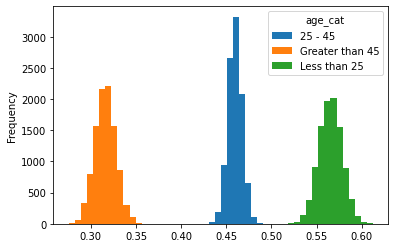

In [7]:
bss.plot.hist(bins=50)

## Binomial

In [8]:
params = pandas.DataFrame({
    'N': data.groupby('age_cat').size(),
    'k': data.groupby('age_cat')['two_year_recid'].sum()
})

In [9]:
params

,N,k
age_cat,,
25 - 45,4109,1889
Greater than 45,1576,498
Less than 25,1529,864


In [10]:
params['k'] / params['N']

age_cat
25 - 45            0.459723
Greater than 45    0.315990
Less than 25       0.565075
dtype: float64

In [18]:
binomial = params.apply(
    lambda x: binom.rvs(x['N'], x['k']/x['N'], size=5000)/x['N'], axis=1, result_type='expand').T

<AxesSubplot:ylabel='Frequency'>

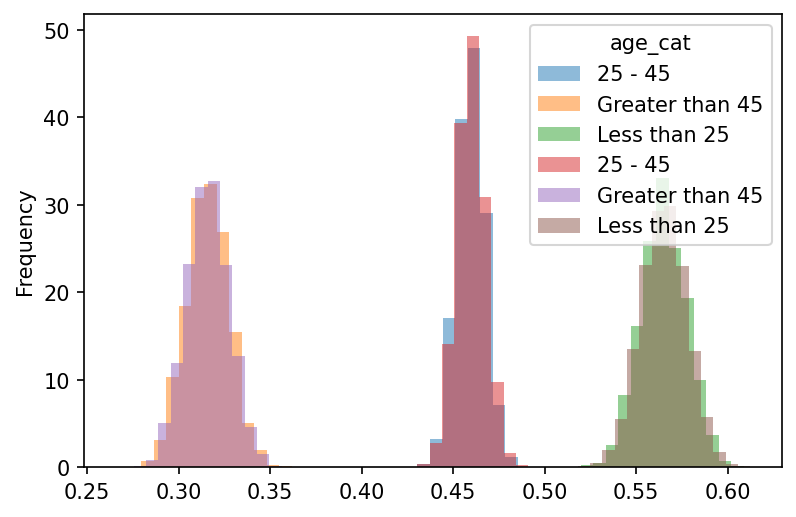

In [22]:
ax = binomial.plot.hist(bins=50, density=True, alpha=0.5)
bss.plot.hist(bins=50, density=True, alpha=0.5, ax=ax)

## Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
X = pandas.get_dummies(data['age_cat'], drop_first=True)
y = data['two_year_recid']

In [25]:
X

,Greater than 45,Less than 25
0,1,0
1,0,0
2,0,1
3,0,1
4,0,0
...,...,...
7209,0,1
7210,0,1
7211,1,0
7212,0,0


In [26]:
model = LogisticRegression(penalty='none').fit(X, y)

In [28]:
model.coef_

array([[-0.61080397,  0.42324471]])

In [29]:
model.intercept_

array([-0.16145935])

In [30]:
p = data.groupby('age_cat')['two_year_recid'].mean()

In [32]:
p

age_cat
25 - 45            0.459723
Greater than 45    0.315990
Less than 25       0.565075
Name: two_year_recid, dtype: float64

In [31]:
np.log(p['25 - 45'] / (1 - p['25 - 45']))

-0.16145960736481563

In [33]:
np.log(p['Greater than 45']/ (1 - p['Greater than 45']) / p['25 - 45'] * (1 - p['25 - 45']))

-0.6108030670794741

In [34]:
df = X.join(y)

In [35]:
feat = X.columns

In [36]:
coef, intercept = [], []

for _ in range(500):
    sample = df.sample(df.shape[0], replace=True)
    m = LogisticRegression(penalty='none').fit(sample[feat], sample['two_year_recid'])
    coef.append(m.coef_[0])
    intercept.append(m.intercept_[0])

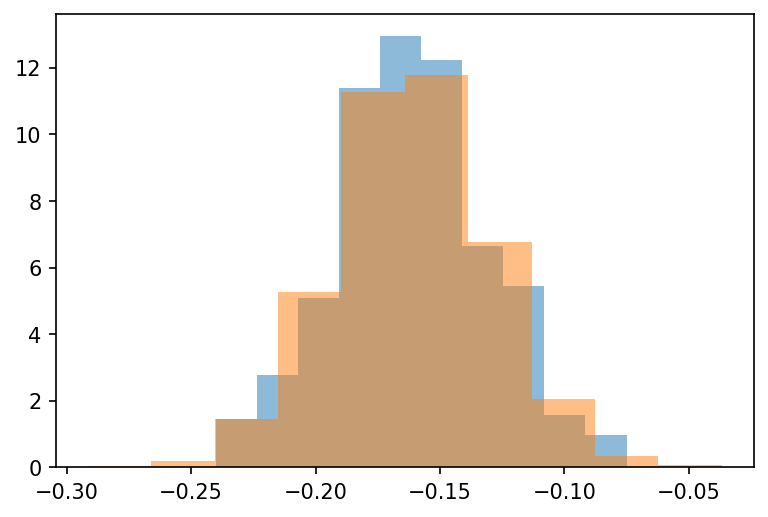

In [43]:
plt.hist(intercept, alpha=0.5, density=True)
plt.hist(np.log(bss['25 - 45'] / (1-bss['25 - 45'])), alpha=0.5, density=True)
None